<a href="https://colab.research.google.com/github/hbgit/walletstockanalysis/blob/main/ReviewMyWalletStonks_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#PRIO3 = yf.Ticker("PRIO3.SA")
#print(PRIO3.info.keys())

**Stock Wallet**

In [4]:
stock_list = ['ABBV','PEP','PLD','KO','STOR','PRU','MSFT','VZ','T','GOOGL','AMZN']

In [5]:
#earningsGrowth; yield; totalRevenue
metric = [
    'marketCap',
    'revenueGrowth',
    'pegRatio',
    'returnOnAssets',
    'returnOnEquity',
    'profitMargins',
    'currentRatio',
    'debtToEquity',
    'payoutRatio',
    'recommendationMean',
    'recommendationKey',
    'totalDebt',
    'sector',
    'dividendYield',
    'averageVolume',
    'totalRevenue'
]

In [6]:
df = pd.DataFrame(index=stock_list,columns=metric)

In [7]:
def get_fundamental_data(df):
  for symbol in df.index:
    get_sym_info = yf.Ticker(symbol)
    print("Getting symbol: " + symbol)
    try:
      for metric in df.columns:        
        get_sym_info.info[metric]
        df.loc[symbol,metric] = get_sym_info.info[metric]
    except Exception as e:
      print (symbol, 'not found')
  return df
      

In [8]:
# Defining rules to check fundamentals
# gt -> great than >= 
rulesFundmentals_gt = {
    'marketCap' : 200000000000,
    'revenueGrowth' : 0.052,
    'pegRatio' : 2.0,
    'returnOnAssets' : 0.08000,
    'returnOnEquity' : 0.20000,
    'profitMargins' : 0.11282,
    'currentRatio' : 1.0,
    'debtToEquity' : 11.00,   
    'averageVolume' : 1700000
}

In [9]:
df = get_fundamental_data(df)

Getting symbol: ABBV
Getting symbol: PEP
Getting symbol: PLD
Getting symbol: KO
Getting symbol: STOR
Getting symbol: PRU
Getting symbol: MSFT
Getting symbol: VZ
Getting symbol: T
Getting symbol: GOOGL
Getting symbol: AMZN


In [10]:
df

,marketCap,revenueGrowth,pegRatio,returnOnAssets,returnOnEquity,profitMargins,currentRatio,debtToEquity,payoutRatio,recommendationMean,recommendationKey,totalDebt,sector,dividendYield,averageVolume,totalRevenue
ABBV,253068165120,0.045,-34.77,0.08139,0.92706,0.22035,0.844,498.284,0.7666,2.2,buy,73187999744,Healthcare,0.039,5411585,57349001216
PEP,238839791616,0.088,3.17,0.08384,0.5571,0.11614,0.918,205.095,0.6366,2.5,buy,39245000704,Consumer Defensive,0.0263,4596114,83643998208
PLD,94180532224,0.089,-4.67,0.02311,0.10523,0.69764,1.048,47.653,0.568,1.8,buy,18524532736,Real Estate,0.0299,3970246,5352833024
KO,242006294528,0.118,4.55,0.08098,0.39211,0.23162,1.127,172.628,0.7818,2.1,buy,42816999424,Consumer Defensive,0.0312,12905176,41322000384
STOR,8893333504,0.163,4.33,0.03037,0.0627,0.38502,1.975,87.962,1.2941,3.1,hold,4715901952,Real Estate,0.0522,5175896,853148032
PRU,35868237824,-0.179,-1.66,0.0028,0.04732,0.03331,1.194,118.089,0.8545,2.9,hold,34148999168,Financial Services,0.0493,1755114,64300998656
MSFT,1763641786368,0.124,1.59,0.14919,0.47151,0.36686,1.785,47.075,0.2508,1.7,buy,78399995904,Technology,0.0114,25673675,198269992960
VZ,153583386624,0.001,2.13,0.04631,0.26241,0.15484,0.762,205.118,0.5141,2.9,hold,179184992256,Communication Services,0.0704,22524570,134325002240
T,110738038784,-0.171,-1.28,0.04205,0.11311,0.12725,0.701,119.978,0.7058,2.7,hold,162337996800,Communication Services,0.0712,42937309,156602007552
GOOGL,1303349690368,0.126,2.19,0.14927,0.29216,0.25892,2.809,11.28,0,1.8,buy,28810000384,Communication Services,None,27603217,278139011072


In [44]:
# Print Bar Chart
def print_bar_chart_from_json(json_file):
  #dictionary = json.load(open('file.json', 'r'))
  xAxis = [key for key, value in json_file.items()]
  yAxis = [value for key, value in json_file.items()]
  plt.grid(True)

  ## BAR GRAPH ##
  #fig = plt.figure()
  plt.bar(xAxis,yAxis,color='#CD3333')
  plt.xlabel('Stonks')
  plt.ylabel('Return')

  plt.show()

In [45]:
def check_peformace_last_months(list_symbol):
    # Collect data from the last 6 months
    #TODO: 6mo ou 2y?
    data = yf.download(list_symbol,period = "6mo")['Adj Close']

    # https://capitalresearch.com.br/blog/calcular-rentabilidade/
    # Return  
    dict_return = {}  
    for symbol in data.columns:
      if not pd.isna(data[symbol].iloc[0]):
        dict_return[symbol] = ((data[symbol].iloc[-1]/data[symbol].iloc[0])*100)-100
      else:
        dict_return[symbol] = ((data[symbol].iloc[-1]/data[symbol].iloc[1])*100)-100

    worst_return = {}
    for e in dict_return.keys():
      if dict_return[e] <= -25.00:
        worst_return[e] = dict_return[e]
    
    #print(json.dumps(worst_return, sort_keys=True, indent=4))
    print_bar_chart_from_json(worst_return)

    # ----------------- Plot all the close prices  ----------------- 
    # Pandas dataframe. pct_change() function calculates the percentage change between the current and a prior element.
    # Return cumulative product over a DataFrame or Series axis.
    # The next step is to calculate the simple daily returns of the stocks. The formula to calculate this rate is to divide each day by the previous day minus 1.
    ((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

    # Show the legend
    plt.legend()

    # Define the label for the title of the figure
    plt.title("Returns", fontsize=16)

    # Define the labels for x-axis and y-axis
    plt.ylabel('Cumulative Returns', fontsize=14)
    plt.xlabel('Year', fontsize=14)

    # Plot the grid lines
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.show()
    

In [46]:
rules_broken_by_symbol = []
metric_broken_by_symbol = {}
def check_fundamentals_data(df):
  for symbol in df.index:
    count_broken_rules = 0
    tmp_metrics = []
    #print("Checking symbol: " + symbol)  
    #print(">>> Rule broken: " + str(rulesFundmentals_gt.get('marketCap')) )      
    
    for metric in df.columns:                                               
      if metric in rulesFundmentals_gt:                        
        if df.loc[symbol,metric] is not None:                        
          if df.loc[symbol,metric] < rulesFundmentals_gt[metric]:
            count_broken_rules += 1 
            tmp_metrics.append(df.loc[symbol,metric])
            tmp_metrics.append(rulesFundmentals_gt[metric])              
            metric_broken_by_symbol[symbol] = tmp_metrics
          if metric == "payoutRatio":
            if df.loc[symbol,metric] > 1.0:
              count_broken_rules += 1
              tmp_metrics.append(df.loc[symbol,metric])
              tmp_metrics.append(rulesFundmentals_gt[metric])              
              metric_broken_by_symbol[symbol] = tmp_metrics
          if metric == "recommendationKey":
            if df.loc[symbol,metric] ==  "sell":
              count_broken_rules += 1
              tmp_metrics.append(df.loc[symbol,metric])
              tmp_metrics.append(rulesFundmentals_gt[metric])              
              metric_broken_by_symbol[symbol] = tmp_metrics
            elif df.loc[symbol,metric] ==  "hold":
              if df.loc[symbol,"recommendationMean"] > 3.5:
                count_broken_rules += 1
                tmp_metrics.append(df.loc[symbol,"recommendationMean"])
                tmp_metrics.append(3.6)   

      if count_broken_rules >= 3: # number of rules that was broken        
        rules_broken_by_symbol.append(symbol)
      else:
        if symbol in metric_broken_by_symbol.keys():
          metric_broken_by_symbol.pop(symbol) 
    
    #try:      
    #except Exception as e:
    #  print (symbol, 'not found')

  # Useful data
  print("Stocks that broken the rules: ")  
  #print(json.dumps(metric_broken_by_symbol, sort_keys=True, indent=4))
  check_peformace_last_months(rules_broken_by_symbol)


Stocks that broken the rules: 
[*********************100%***********************]  7 of 7 completed


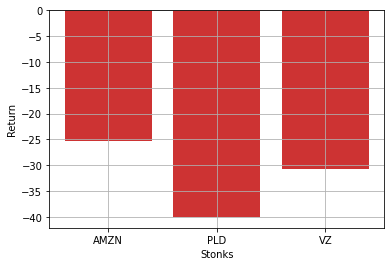

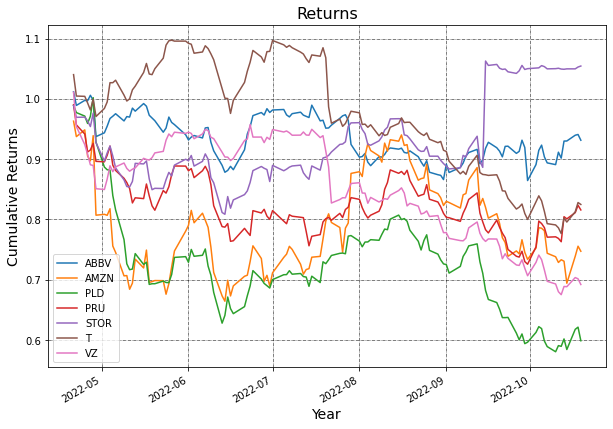

In [47]:
check_fundamentals_data(df)

In [ ]:
# ETFs analysis

In [ ]:
# https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap.html
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
# 